# 랜덤포레스트_예측

In [25]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
import graphviz
from graphviz import Source
from sklearn import tree
import pydot

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
%matplotlib inline

# 한글 폰트 적용
matplotlib.rc('font', family = 'Nanumgothic')

# 음수 표시
matplotlib.rc('axes', unicode_minus=False)
from sklearn.ensemble import RandomForestRegressor



In [6]:
df_raw = pd.read_csv('./Data/Concrete.csv', engine = 'python')
df_raw.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [7]:
df_raw_y = df_raw['strength']
df_raw_x = df_raw.drop('strength', axis = 1, inplace = False)

In [8]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y,
                                                               test_size = 0.4, random_state = 1234)

print('train data X size: {}'.format(df_train_x.shape))
print('train data Y size: {}'.format(df_train_y.shape))
print('test data X size: {}'.format(df_test_x.shape))
print('test data Y size: {}'.format(df_test_y.shape))


train data X size: (618, 8)
train data Y size: (618,)
test data X size: (412, 8)
test data Y size: (412,)


mse를 기준으로 생성한 랜덤포레스트 모델

In [9]:
rf_uncustomized = RandomForestRegressor(criterion = 'mse', random_state = 1234)
rf_uncustomized.fit(df_train_x, df_train_y)

print('Score on traing set: {:.3f}'.format(rf_uncustomized.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(rf_uncustomized.score(df_test_x, df_test_y)))



Score on traing set: 0.980
Score on test set: 0.904


랜덤포레스트 기본 모델 역시 의사결정모델처럼 test 데이터에도 성능이 좋다

몇 개의 tree를 생성할 지 결정한다.

In [10]:
train_score = []
test_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf= RandomForestRegressor(n_estimators = v_n_estimators, random_state = 1234)
    
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n['n_estimators'] = para_n_tree
df_score_n['TrainScore'] = train_score
df_score_n['TestScore'] = test_score

df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.973,0.905
1,20,0.978,0.905
2,30,0.979,0.903
3,40,0.979,0.905
4,50,0.980,0.905
5,60,0.980,0.906
6,70,0.980,0.906
7,80,0.980,0.906
8,90,0.980,0.905
9,100,0.980,0.904


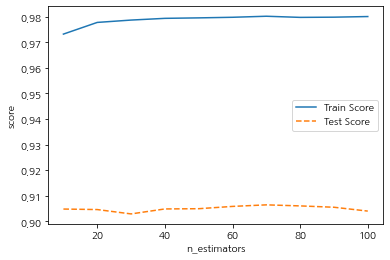

In [11]:
plt.plot(para_n_tree, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_n_tree, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('n_estimators')
plt.legend()

n이 증가해도 거의 일정하기 때문에 n은 50으로 설정한다.

In [14]:
train_score = []
test_score = []

para_leaf = [n_leaf for n_leaf in range(1, 20)]

for v_min_samples_leaf in para_leaf:
    tree= RandomForestRegressor(random_state = 1234,n_estimators = 50, min_samples_leaf = v_min_samples_leaf)
    
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSmaplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

df_score_leaf.round(3)

,MinSmaplesLeaf,TrainScore,TestScore
0,1,0.980,0.905
1,2,0.967,0.900
2,3,0.952,0.891
3,4,0.938,0.878
4,5,0.925,0.869
5,6,0.913,0.857
6,7,0.902,0.850
7,8,0.895,0.846
8,9,0.886,0.836
9,10,0.876,0.823


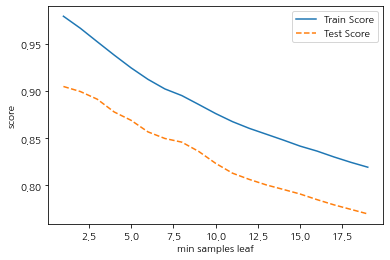

In [13]:
plt.plot(para_leaf, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('min samples leaf')
plt.legend()

특별히 중간에 증가하는 구간이 없기 때문에 leaf node의 최소 데이터 수는 3으로 설정한다.

In [15]:
train_score = []
test_score = []

para_split = [n_split * 2 for n_split in range(2, 20)]

for v_min_samples_split in para_split:
    tree= RandomForestRegressor(random_state = 1234, n_estimators = 50, min_samples_leaf = 3,
                               min_samples_split = v_min_samples_split)
    
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split['MinSmaplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score

df_score_split.round(3)



,MinSmaplesSplit,TrainScore,TestScore
0,4,0.952,0.891
1,6,0.952,0.891
2,8,0.947,0.887
3,10,0.938,0.880
4,12,0.930,0.874
5,14,0.922,0.868
6,16,0.914,0.862
7,18,0.907,0.855
8,20,0.899,0.846
9,22,0.893,0.838


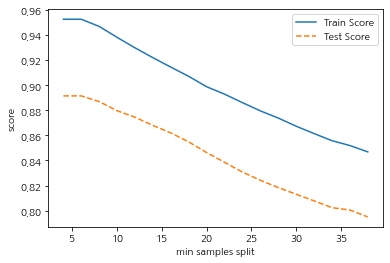

In [16]:
plt.plot(para_split, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_split, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('min samples split')
plt.legend()

split node의 데이터 수는 8로 설정한다.

In [17]:
train_score = []
test_score = []

para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    tree= RandomForestRegressor(random_state = 1234, n_estimators = 50, min_samples_leaf = 3,
                               min_samples_split = 8, max_depth = v_max_depth)
    
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score

df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.336,0.327
1,2,0.612,0.591
2,3,0.737,0.693
3,4,0.816,0.772
4,5,0.881,0.831
5,6,0.914,0.864
6,7,0.931,0.877
7,8,0.940,0.883
8,9,0.944,0.886
9,10,0.946,0.887


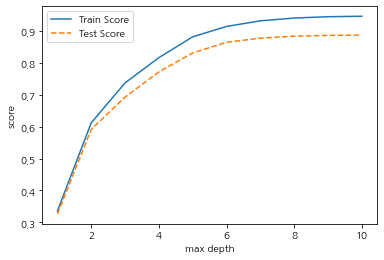

In [18]:
plt.plot(para_depth, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_depth, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('max depth')
plt.legend()

depth는 8로 설정한다.

In [19]:
rf_final = RandomForestRegressor(random_state = 1234, n_estimators = 50, min_samples_leaf = 3,
                                min_samples_split = 8, max_depth = 8)
rf_final.fit(df_train_x, df_train_y)

print('Score on training set: {:.3f}'.format(rf_final.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(rf_final.score(df_test_x, df_test_y)))

Score on training set: 0.940
Score on test set: 0.883


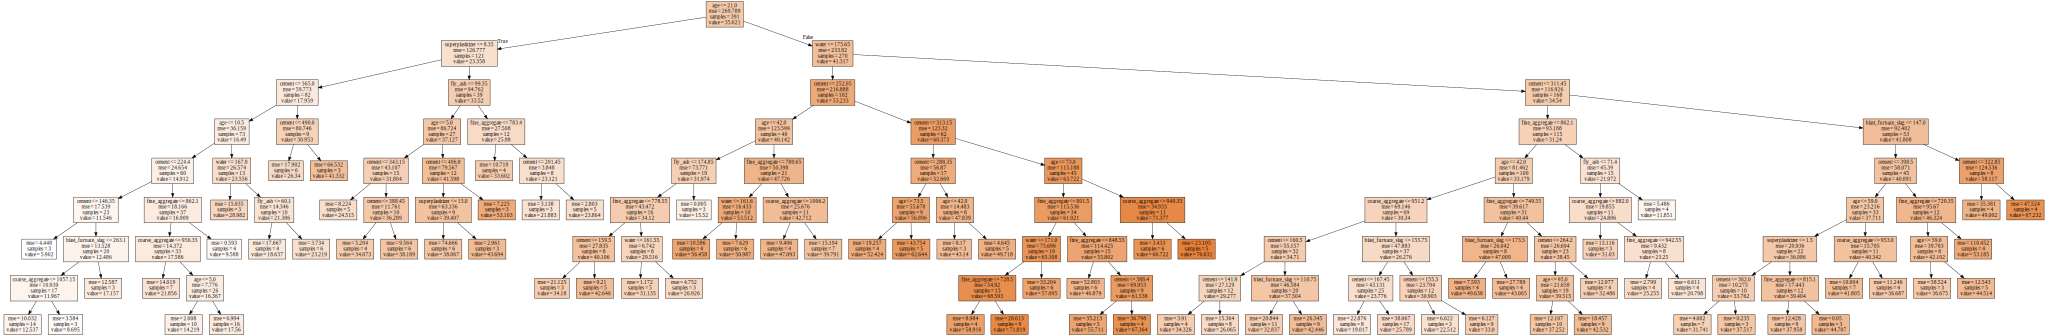

In [27]:
v_feature_name = df_train_x.columns

export_graphviz(rf_final.estimators_[0], out_file = 'rf_final_0.dot',
               feature_names = v_feature_name, impurity = True, filled= True)
with open('rf_final_0.dot') as f:
    dot_graph = f.read()
# 크기 조정
pdot = pydot.graph_from_dot_data(dot_graph)
# Access element [0] because graph_from_dot_data actually returns a list of DOT elements.
pdot[0].set_graph_defaults(size = "\"50,50\"")
graph = Source(pdot[0].to_string())
graph

# display(graphviz.Source(dot_graph))

랜덤포레스트 모델에 대해 mse를 기준으로 데이터를 예측했을 때 콘크리트 최대 강도는 76.031이 나왔다. 중간에 mse가 115에서 34로 하락한 경로 있는데 이때 쓰인 변수가 coarse_aggregate로 중요변수라고 볼 수 있다.

mae를 기준으로 생성한 랜덤 포레스트 모델

In [31]:
train_score = []
test_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf= RandomForestRegressor(criterion = 'mae', n_estimators = v_n_estimators, random_state = 1234)
    
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n['n_estimators'] = para_n_tree
df_score_n['TrainScore'] = train_score
df_score_n['TestScore'] = test_score

df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.971,0.893
1,20,0.977,0.899
2,30,0.977,0.900
3,40,0.979,0.901
4,50,0.979,0.903
5,60,0.979,0.904
6,70,0.980,0.904
7,80,0.979,0.903
8,90,0.979,0.903
9,100,0.980,0.902


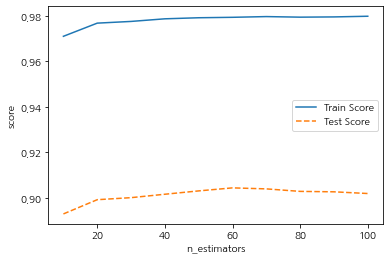

In [32]:
plt.plot(para_n_tree, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_n_tree, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('n_estimators')
plt.legend()

mae에서도 마찬가지로 n의 갯수에 따라 모델의 성능에 큰 차이가 없으므로 50으로 지정한다.

In [35]:
train_score = []
test_score = []

para_leaf = [n_leaf for n_leaf in range(1, 20)]

for v_min_samples_leaf in para_leaf:
    tree= RandomForestRegressor(criterion = 'mae', random_state = 1234,n_estimators = 50, min_samples_leaf = v_min_samples_leaf)
    
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSmaplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

df_score_leaf.round(3)

,MinSmaplesLeaf,TrainScore,TestScore
0,1,0.979,0.903
1,2,0.956,0.891
2,3,0.938,0.874
3,4,0.923,0.861
4,5,0.910,0.854
5,6,0.898,0.842
6,7,0.892,0.836
7,8,0.885,0.833
8,9,0.877,0.820
9,10,0.868,0.811


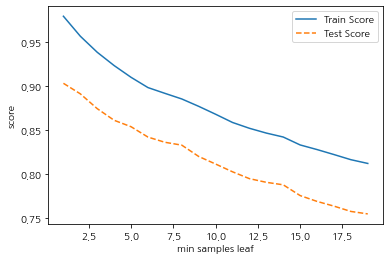

In [36]:
plt.plot(para_leaf, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('min samples leaf')
plt.legend()

잎사귀 노드의 최소 자료 수 증가에 따라 모델의 설명력이 감소하여 3으로 설정한다.

In [37]:
train_score = []
test_score = []

para_split = [n_split * 2 for n_split in range(2, 20)]

for v_min_samples_split in para_split:
    tree= RandomForestRegressor(criterion = 'mae', random_state = 1234, n_estimators = 50, min_samples_leaf = 3,
                               min_samples_split = v_min_samples_split)
    
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split['MinSmaplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score

df_score_split.round(3)



,MinSmaplesSplit,TrainScore,TestScore
0,4,0.938,0.874
1,6,0.938,0.874
2,8,0.932,0.869
3,10,0.926,0.866
4,12,0.920,0.862
5,14,0.914,0.857
6,16,0.907,0.845
7,18,0.902,0.843
8,20,0.893,0.836
9,22,0.887,0.827


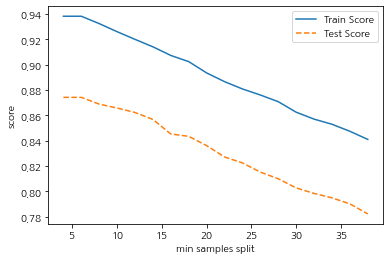

In [38]:
plt.plot(para_split, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_split, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('min samples split')
plt.legend()

분리노드의 최소 자료수 증가에 따라 모델의 설명력은 감소하며 10으로 설정한다.

In [40]:
train_score = []
test_score = []

para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    tree= RandomForestRegressor(criterion = 'mae', random_state = 1234, n_estimators = 50, min_samples_leaf = 3,
                               min_samples_split = 10, max_depth = v_max_depth)
    
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score

df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.290,0.268
1,2,0.616,0.587
2,3,0.723,0.679
3,4,0.808,0.758
4,5,0.862,0.813
5,6,0.896,0.843
6,7,0.911,0.857
7,8,0.919,0.863
8,9,0.924,0.865
9,10,0.925,0.868


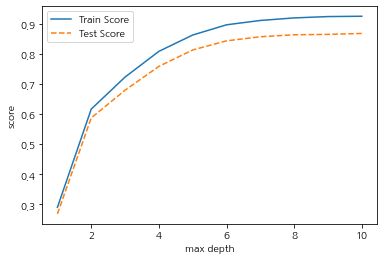

In [41]:
plt.plot(para_depth, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_depth, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score')
plt.xlabel('max depth')
plt.legend()

최대 깊이 증가에 따라 모델의 설명력은 증가하며 8로 설정한다.

In [42]:
rf_final = RandomForestRegressor(criterion = 'mae', random_state = 1234, n_estimators = 50, min_samples_leaf = 3,
                                min_samples_split = 10, max_depth = 8)
rf_final.fit(df_train_x, df_train_y)

print('Score on training set: {:.3f}'.format(rf_final.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(rf_final.score(df_test_x, df_test_y)))

Score on training set: 0.919
Score on test set: 0.863


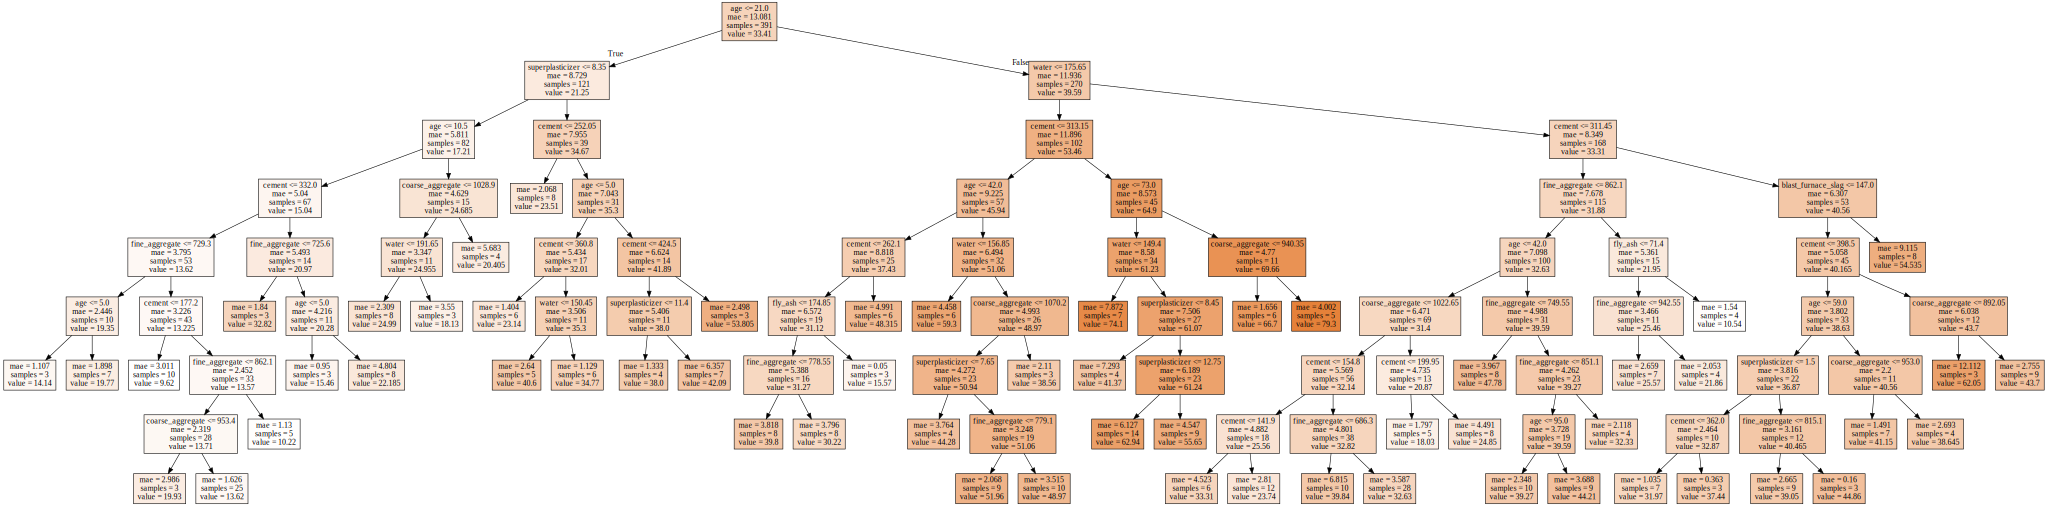

In [43]:
v_feature_name = df_train_x.columns

export_graphviz(rf_final.estimators_[0], out_file = 'rf_final_0.dot',
               feature_names = v_feature_name, impurity = True, filled= True)
with open('rf_final_0.dot') as f:
    dot_graph = f.read()
pdot = pydot.graph_from_dot_data(dot_graph)
# Access element [0] because graph_from_dot_data actually returns a list of DOT elements.
pdot[0].set_graph_defaults(size = "\"50,50\"")
graph = Source(pdot[0].to_string())
graph

# display(graphviz.Source(dot_graph))

mae를 기준으로 했을 때 콘크리트의 최대 강도는 79.3이 나왔다. 이는 의사결정나무로 예측한 값과 거의 유사한 것을 볼 수 있다.

In [22]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_

df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
7,age,0.362
0,cement,0.266
3,water,0.154
4,superplasticizer,0.082
1,blast_furnace_slag,0.050
6,fine_aggregate,0.045
5,coarse_aggregate,0.025
2,fly_ash,0.016


Text(0, 0.5, '변수')

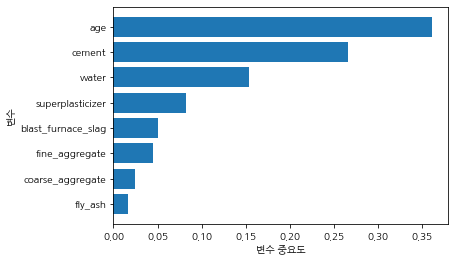

In [23]:
df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

앞서서 의사결정 나무에서 봤던 것과 결과가 같다. age, cement, water 등이 콘크리트 강도에 대한 중요변수라고 할 수 있다.

In [28]:
estimator = RandomForestRegressor()

param_grid = {'max_depth': para_depth, 'min_samples_split': para_split,
             'min_samples_leaf': para_leaf}

# scoring = 'r2' -> 결정계수로 scoring
grid_dt = GridSearchCV(estimator, param_grid, scoring = 'r2', n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)


print('best estimator model: \n{}'.format(grid_dt.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_dt.best_params_))
print('\nbest score: \n{}'.format(grid_dt.best_score_.round(3)))

best estimator model: 
RandomForestRegressor(max_depth=10, min_samples_split=4)

best parameter: 
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4}

best score: 
0.87


> 결론  <br>
콘크리트의 최대 강도는 의사결정나무와 랜덤포레스트를 사용해서 각각 비교했을 때 거의 차이가 없는 것을 볼 수 있다.  
mse값의 경우 데이터가 많다보니 파라미터를 설정해도 10이하로 잘 줄어들지 않는 모습을 보였다.  
변수 중요도는 수치그래프로 판단한 것과 graphviz로 그래프를 보면서 판단한 것과는 약간의 차이가 느껴졌다.   
의사결정나무와 랜덤포레스트 모두 mse끼리, mae끼리 예측했을 때의 그 예측값이 비슷한 것으로 보아 예측의 기준을 어떤 값으로 할 지가 중요하다고 생각된다.